In [1]:
import numpy as np
import array
import matplotlib.pyplot as plt

%matplotlib notebook

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

## Target Function
$y = x^2$

In [2]:
# This is the unknown function from which we sample
# Model is required to fit samples from this function in MSE sense

def target_fn(x):
    return np.power(x, 2)

def sample(size, sample_min=-1, sample_max=1):
    x = np.sort((sample_min - sample_max)*np.random.rand(size)+sample_max)
    y = target_fn(x)
    
    return x, y

In [3]:
# preparing the dataset

DATASET_SIZE = 100
SAMPLE_MIN = -1
SAMPLE_MAX = 1

ds_x, ds_y = sample(DATASET_SIZE, SAMPLE_MIN, SAMPLE_MAX)
ds = (ds_x, ds_y)

## Model
The model here is a quadratic polynomial having the general formula

$y = w_1*x^2 + w_2*x + w_3$

where $w_i$ is a model parameter to be optimized by the evolutionary algorithm

In [4]:
# Initializing DEAP

# creator.create is used to define the needed data types

# Define the fitness. A negative weight means we want to minimize

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Define individual and strategy parameters

creator.create("Individual", array.array, typecode="d",
               fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", array.array, typecode="d")

# Define the initialization function for an ES individual and strategy parameters

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls((imin-imax)*np.random.rand(1)+imax for _ in range(size))
    ind.strategy = scls((smin-smax)*np.random.rand(1)+smax for _ in range(size))
    return ind

# Define the individual size, i.e number of parameters, and the range of random initialization

IND_SIZE = 3
MIN_VALUE, MAX_VALUE = -5., 5.
MIN_STRAT, MAX_STRAT = -1., 1. 

# toolbox.register is used to define aliases, here for initializing indvidual and population

toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=IND_SIZE)

# Compute the prediction made by an individual parameters

def indPred(ind, ds):
    ds_x = ds[0]
    
    o = np.zeros(len(ds_x))
    
    for i in range(0, 3):
        o += ind[i]*np.power(ds_x, i)
        
    return o

# Compute fitness based on prediction, made by individual, and target output

def evaluateInd(ind, ds):
    o = indPred(ind, ds)
    
    return np.mean(np.power(np.array(ds_y) - o, 2)),

# Define basic evolutionary operators

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluateInd, ds=ds)

# Define needed stats

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

In [5]:
# Auxiliary for updating the graph in runtime

def upd_plt(plt, line, o, fitness):
    line.set_ydata(o)
    line.axes.get_figure().canvas.draw()
    plt.legend([line], [fitness])

<IPython.core.display.Javascript object>


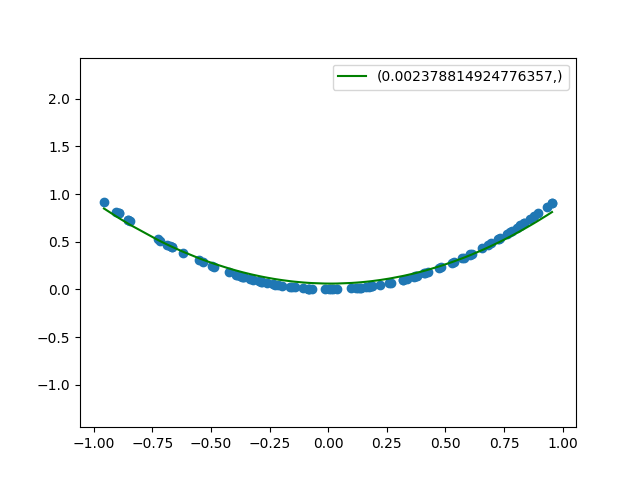

In [ ]:
# Initialize plot

fig = plt.figure()
ax = fig.add_subplot(111)
scat = ax.scatter(ds_x, ds_y)

fig.show()
plt.ion()

# Initialize random population

pop = toolbox.population()

# Number of generations

NGEN = 500

# Select the initially fittest indivdual, compute its prediction

best = tools.selBest(pop, 1)[0]
o = indPred(best, ds)

# Initialize the fitting curve based on initial fittest individual

line, = ax.plot(ds_x, o, 'g-')
plt.legend([line], [best.fitness])

# Evolution loop

for gen in range(1, NGEN+1):
    
    # Evolve one generation
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, verbose=False)

    # Select fittest individual and update the fitting curve by its prediction
    
    best = tools.selBest(pop, 1)[0]

    o = indPred(best, ds)

    upd_plt(plt, line, o, best.fitness)